In [1]:
import torch
from sentence_transformers import SentenceTransformer
import pandas as pd


df = pd.read_csv("../data/label_encoded_telecom_data.csv")

model = SentenceTransformer("all-MiniLM-L6-v2")

final_columns = [column for column in df.columns if column not in ['customerID', 'tenure', 'TotalCharges', 'MonthlyCharges']]

2024-12-08 15:24:16.691901: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 15:24:16.720766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 15:24:16.720794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 15:24:16.721738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 15:24:16.726213: I tensorflow/core/platform/cpu_feature_guar

In [2]:
result = model.encode(final_columns)
result.shape

(17, 384)

In [6]:
len(final_columns)

17

In [4]:
mean_list = []
for column_vector in result:
    mean_list.append(column_vector.mean())

In [5]:
demographics = ['SeniorCitizen', 'Partner', 'gender', 'Dependents']
services = [column for column in df.columns if column not in demographics and column not in ['Contract', 'Churn', 'PaperlessBilling', 'PaymentMethod','customerID', 'tenure', 'TotalCharges', 'MonthlyCharges']]


In [6]:
demographics_means = {}
services_means = {}
for column in df.columns:
    if column in demographics:
        demographics_means[column] = model.encode(column).mean()
    elif column in services:
        services_means[column] = model.encode(column).mean()

In [7]:
new_df = df.drop(services + demographics, axis=1)

new_df['service_score'] = df[services].apply(lambda row: sum(row[col] * services_means[col] for col in services), axis=1)
new_df['demographics_score'] = df[demographics].apply(lambda row: sum(row[col] * demographics_means[col] for col in demographics), axis=1)

In [8]:
new_df

,customerID,tenure,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,service_score,demographics_score
0,5375,1,0,1,2,29.85,29.85,0,0.003219,0.001074
1,3962,34,1,0,3,56.95,1889.50,0,0.003268,0.001396
2,2564,2,0,1,3,53.85,108.15,1,0.004107,0.001396
3,5535,45,1,0,0,42.30,1840.75,0,0.005915,0.001396
4,6511,2,0,1,2,70.70,151.65,1,0.000693,0.000000
...,...,...,...,...,...,...,...,...,...,...
7027,4853,24,1,1,3,84.80,1990.50,0,0.013577,0.002946
7028,1525,72,1,1,1,103.20,7362.90,0,0.012600,0.001550
7029,3367,11,0,1,2,29.60,346.45,0,0.002842,0.001550
7030,5934,4,0,1,3,74.40,306.60,1,0.002899,0.003213


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove the customerID column
new_df = df.drop(columns=['customerID'])

# Define the features and target variable
X = new_df.drop(columns=['Churn'])
y = new_df['Churn']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard scale the specified columns
scaler = StandardScaler()
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

X_train.head(), X_test.head(), y_train.head(), y_test.head()


(      gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
 6021       0              0        0           0  0.434674             0   
 3404       1              0        0           0 -1.195652             1   
 5474       0              0        1           0  0.923772             1   
 5515       1              0        1           1  0.516190             1   
 6328       0              0        1           1  0.923772             1   
 
       MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
 6021              1                0               0             0   
 3404              0                0               0             0   
 5474              2                1               0             0   
 5515              0                0               2             0   
 6328              2                1               2             0   
 
       DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
 6021                 2     

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.utils import resample

# Separate the majority and minority classes
X_train_majority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 0]
X_train_minority = X_train[y_train == 1]
y_train_minority = y_train[y_train == 1]

# Oversample the minority class
X_train_minority_oversampled, y_train_minority_oversampled = resample(X_train_minority, y_train_minority, 
                                                                      replace=True, n_samples=len(X_train_majority), 
                                                                      random_state=42)

# Combine the majority class with the oversampled minority class
X_train_oversampled = pd.concat([X_train_majority, X_train_minority_oversampled])
y_train_oversampled = pd.concat([y_train_majority, y_train_minority_oversampled])

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5,],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Create a GridSearchCV object with F1 score as the scoring metric
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(f1_score))

# Fit the model
grid_search.fit(X_train_oversampled, y_train_oversampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# Calculate the F1 score on the test set
test_f1_score = f1_score(y_test, y_pred)
print("Test F1 Score:", test_f1_score)

print(classification_report(y_train_oversampled, grid_search.predict(X_train_oversampled)))

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best F1 Score: 0.7811130915633938
Test F1 Score: 0.5848074921956296
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      4130
           1       0.76      0.83      0.79      4130

    accuracy                           0.78      8260
   macro avg       0.78      0.78      0.78      8260
weighted avg       0.78      0.78      0.78      8260

[0.10939466 0.62708704 0.         0.00947335 0.16855482 0.04617554
 0.0322961  0.00701849]


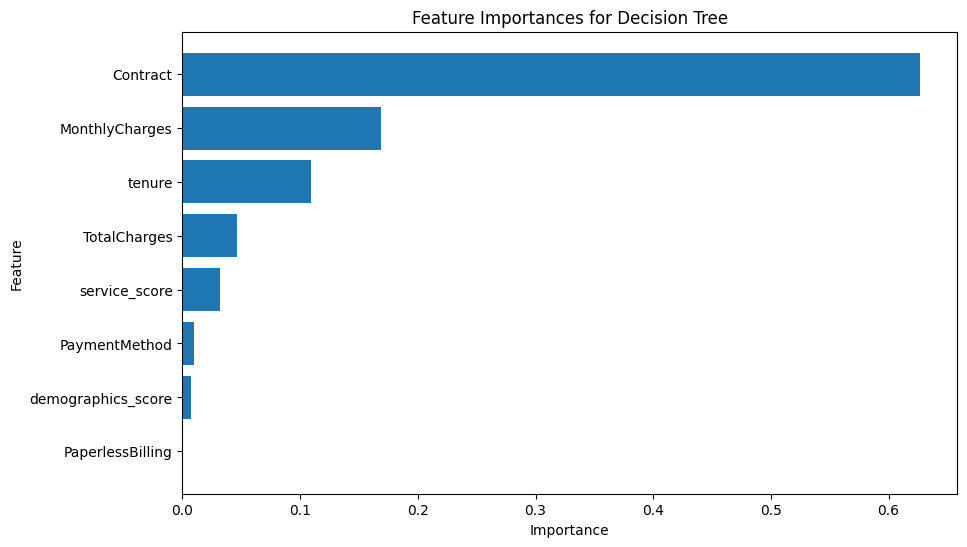

In [33]:
import matplotlib.pyplot as plt

# Get feature importances
importances = grid_search.best_estimator_.feature_importances_

# Get feature names
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Decision Tree')
plt.gca().invert_yaxis()
plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for logistic regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Create a logistic regression classifier
lr = LogisticRegression(random_state=42, max_iter=1000)

# Create a GridSearchCV object with F1 score as the scoring metric
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, n_jobs=-1, scoring=make_scorer(f1_score))

# Fit the model
grid_search_lr.fit(X_train_oversampled, y_train_oversampled)

# Get the best parameters and best score
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

# Print the best parameters and best score
print("Best Parameters for Logistic Regression:", best_params_lr)
print("Best F1 Score for Logistic Regression:", best_score_lr)

# Predict on the test set
y_pred_lr = grid_search_lr.predict(X_test)

# Calculate the F1 score on the test set
test_f1_score_lr = f1_score(y_test, y_pred_lr)
print("Test F1 Score for Logistic Regression:", test_f1_score_lr)

print(classification_report(y_train_oversampled, grid_search_lr.predict(X_train_oversampled)))

Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Best F1 Score for Logistic Regression: 0.7735118541890325
Test F1 Score for Logistic Regression: 0.6077457795431976
              precision    recall  f1-score   support

           0       0.79      0.70      0.74      4130
           1       0.73      0.82      0.77      4130

    accuracy                           0.76      8260
   macro avg       0.76      0.76      0.76      8260
weighted avg       0.76      0.76      0.76      8260



[[-1.28186433 -1.01427074  0.40451307  0.02373913  0.71521927  0.5392066
  -0.10088019  0.01199634]]


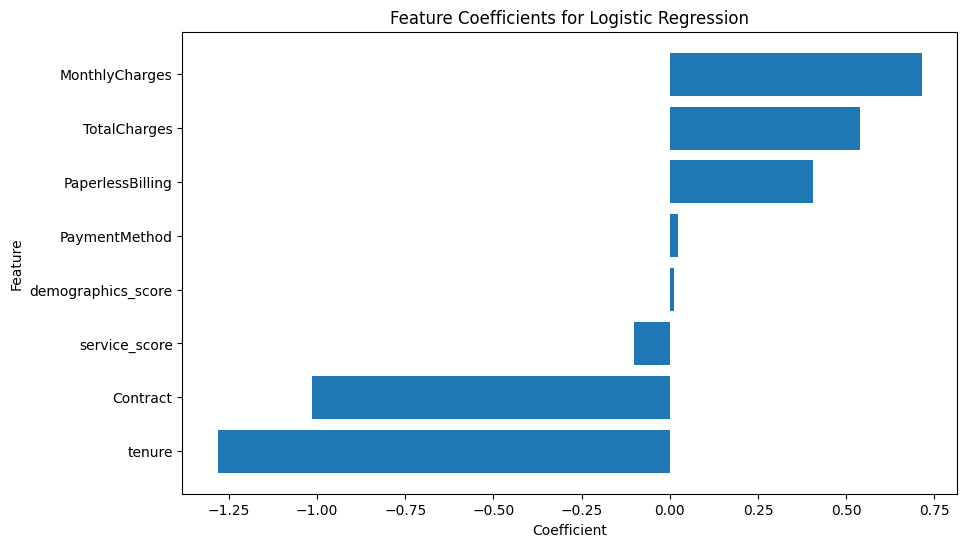

In [36]:
print(grid_search_lr.best_estimator_.coef_)
import matplotlib.pyplot as plt

# Get the coefficients from the best logistic regression model
coefficients = grid_search_lr.best_estimator_.coef_[0]

# Create a DataFrame for visualization
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient value
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

# Plot the coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'])
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Coefficients for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

In [38]:
# Drop the specified columns from X_train and X_test
X_train_new = X_train_oversampled.drop(columns=['service_score', 'demographics_score'])
X_test_new = X_test.drop(columns=['service_score', 'demographics_score'])

# Refit the Decision Tree model
grid_search.fit(X_train_new, y_train_oversampled)

# Get the best parameters and best score
best_params_new = grid_search.best_params_
best_score_new = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters (without service_score and demographics_score):", best_params_new)
print("Best F1 Score (without service_score and demographics_score):", best_score_new)

# Predict on the test set
y_pred_new = grid_search.predict(X_test_new)

# Calculate the F1 score on the test set
test_f1_score_new = f1_score(y_test, y_pred_new)
print("Test F1 Score (without service_score and demographics_score):", test_f1_score_new)

print(classification_report(y_train_oversampled, grid_search.predict(X_train_new)))

Best Parameters (without service_score and demographics_score): {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score (without service_score and demographics_score): 0.7800122382102926
Test F1 Score (without service_score and demographics_score): 0.5780933062880325
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      4130
           1       0.75      0.84      0.79      4130

    accuracy                           0.78      8260
   macro avg       0.79      0.78      0.78      8260
weighted avg       0.79      0.78      0.78      8260



In [89]:
# Find all binary columns
binary_columns = [col for col in X_train.columns if X_train[col].nunique() == 2]

# Find all non-binary columns
non_binary_columns = [col for col in X_train.columns if col not in binary_columns]

# Create a new dataframe with binary columns first and then non-binary columns
new_X_train = X_train[binary_columns + non_binary_columns]

new_X_train.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges
6021,0,0,0,0,0,1,0.434674,1,0,0,0,2,0,2,2,0,0,-0.518620,-0.087908
3404,1,0,0,0,1,0,-1.195652,0,0,0,0,0,0,2,0,0,1,-0.374443,-0.921285
5474,0,0,1,0,1,1,0.923772,2,1,0,0,2,0,0,0,0,2,0.432616,0.963781
5515,1,0,1,1,1,0,0.516190,0,0,2,0,0,2,0,0,2,0,-0.333013,0.122920
6328,0,0,1,1,1,0,0.923772,2,1,2,0,0,0,2,2,1,3,1.199902,1.401088


In [11]:
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
import numpy as np

batch_size = 256
train_target = torch.tensor(y_train.values.astype(np.int32))
train = torch.tensor(X_train.values.astype(np.float32)) 
train_tensor = TensorDataset(train, train_target) 
train_loader = DataLoader(dataset = train_tensor, batch_size = 256, shuffle = True)

In [12]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_loader = DeviceDataLoader(train_loader, device)

In [49]:
from torch import nn

class GeneratorModel(nn.Module):
    

    def __init__(self):
        super(GeneratorModel, self).__init__()
        self.label_embedding = nn.Embedding(2, 2)
        input_dimension = 10 + 2
        output_dimension_binary = 6
        output_dimension_linear = 13
        self.hidden_layer_1 = nn.Sequential(
            nn.Linear(input_dimension, 30),
            nn.LeakyReLU(),
            nn.Dropout()
        )
        
        self.hidden_layer_2 = nn.Sequential(
            nn.Linear(30, 40),
            nn.LeakyReLU(),
            nn.Dropout()
        )

        self.output_layer1 = nn.Sequential(
            nn.Linear(40, output_dimension_binary),
            nn.Softmax(dim=1)
        )
        self.output_layer2 = nn.Sequential(
            nn.Linear(40, output_dimension_linear)
        )


    
    def forward(self, x, labels):
        labels = labels.to(torch.long)
        c = self.label_embedding(labels)
        x = torch.cat([x,c], 1)
        output = self.hidden_layer_1(x)
        output = self.hidden_layer_2(output)
        output_binary = self.output_layer1(output)
        output_linear = self.output_layer2(output)
        output = torch.cat([output_binary, output_linear], 1)
        return output.to(device)

In [50]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        input_dim = 19
        output_dim = 1
        self.label_embedding = nn.Embedding(2, 2)

        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout()
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout()
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
    
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)

        output = self.hidden_layer4(output)

        return output.to(device)

In [51]:
discriminator = DiscriminatorModel()
generator = GeneratorModel()
discriminator.to(device)
generator.to(device)

GeneratorModel(
  (label_embedding): Embedding(2, 2)
  (hidden_layer_1): Sequential(
    (0): Linear(in_features=12, out_features=30, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (hidden_layer_2): Sequential(
    (0): Linear(in_features=30, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.5, inplace=False)
  )
  (output_layer1): Sequential(
    (0): Linear(in_features=40, out_features=6, bias=True)
    (1): Softmax(dim=1)
  )
  (output_layer2): Sequential(
    (0): Linear(in_features=40, out_features=13, bias=True)
  )
)

In [52]:
from torch import optim

lossFunction = nn.BCELoss()
discriminatorOptim = optim.Adam(discriminator.parameters(), lr = 0.0001)
generatorOptim = optim.Adam(generator.parameters(), lr = 0.0001)

In [53]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.autograd as autograd

In [79]:

def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""

    # Random weight term for interpolation between real and fake samples
    alpha = torch.tensor(np.random.random((real_samples.size(0), 1))).float().to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)


    d_interpolates = D(interpolates)
    fake = Variable(torch.FloatTensor(real_samples.shape[0], 1).fill_(1.0).to(device), requires_grad=False)


    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
def fit(data_loader, batch_size, n_epochs, loss, g_opt, d_opt, n_critic = 5):
    lambda_gp = 10
    mean_g_loss = []
    mean_d_loss = []
    for epoch in range(n_epochs):

        G_loss = []
        D_loss = []
        for i, data in enumerate(data_loader):

            batch_size = len(data[1])
            noise = torch.randn(batch_size, 10).to(device)
            data_class = torch.randint(0, 2, (batch_size, )).float().to(device)


            d_opt.zero_grad()


            generated_data = generator(noise, data_class)

            fake_prediction = discriminator(generated_data).view(batch_size)


            true_data_class = Variable(data[1]).to(device)
            true_data = data[0].to(device)

            real_prediction = discriminator(true_data).view(batch_size)

            gradient_penalty = compute_gradient_penalty(discriminator, true_data, generated_data)

            d_loss = -torch.mean(real_prediction) + torch.mean(fake_prediction) + lambda_gp * gradient_penalty

            d_loss.backward()
            
            d_opt.step()

            g_opt.zero_grad()
        
            if (i % n_critic == 0):

                fake = generator(noise, data_class) 
                fake_prediction = discriminator(fake).view(batch_size)

                g_loss = -torch.mean(fake_prediction)

                g_loss.backward()
                g_opt.step()

                print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
                )

                mean_d_loss.append(d_loss.item())
                mean_g_loss.append(g_loss.item())

    

    plt.plot(mean_g_loss, label= "Generator Loss")
    plt.plot(mean_d_loss, label= "Discriminator Loss")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Graph of loss')

    # Adding a legend
    plt.legend()

    # Display the graph
    plt.show()

    
            

In [ ]:
fit(train_loader, batch_size, 200, lossFunction, generatorOptim, discriminatorOptim)

torch.float32 torch.float32
[Epoch 0/200] [Batch 0/22] [D loss: 10.000000] [G loss: -1.000000]
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
[Epoch 0/200] [Batch 5/22] [D loss: 10.000000] [G loss: -1.000000]
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
[Epoch 0/200] [Batch 10/22] [D loss: 10.000000] [G loss: -1.000000]
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
[Epoch 0/200] [Batch 15/22] [D loss: 10.000000] [G loss: -1.000000]
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
torch.float32 torch.float32
[Epoch 0/200] [Batch 20/22] [D loss: 10.000000] [G loss: -1.000000]
torch.float32 torch.float32
torch.float32 torch.float32
[Epoch 1/200] [Bat

In [77]:
# Generate 10,000 random datapoints
num_samples = 10000
noise = torch.randn(num_samples, 10).to(device)
data_class = torch.randint(0, 2, (num_samples, )).float().to(device)
generated_data = generator(noise, data_class)

# Convert the generated data to a pandas DataFrame
generated_df = pd.DataFrame(generated_data.cpu().detach().numpy(), columns=X.columns)
generated_df['Churn'] = data_class.cpu().detach().numpy()

generated_df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.185042,0.156384,0.178105,0.131436,0.181296,0.167736,-0.016865,-0.105815,-0.053186,-0.172749,-0.059698,-0.030590,-0.077091,-0.028659,-0.241728,-0.076758,0.151002,0.155057,-0.080559,0.504300
std,0.026490,0.024163,0.027582,0.018869,0.020795,0.028070,0.151935,0.184663,0.169728,0.191974,0.173430,0.172230,0.171695,0.159302,0.182624,0.142371,0.155359,0.202496,0.165470,0.500006
min,0.084527,0.051687,0.048179,0.054626,0.079699,0.059483,-0.834261,-1.168748,-0.854694,-1.199198,-1.771493,-0.880217,-1.088684,-0.824813,-1.328450,-0.978064,-0.673684,-0.813255,-0.926193,0.000000
25%,0.169330,0.142467,0.162137,0.120002,0.169915,0.150546,-0.102229,-0.197091,-0.149690,-0.286428,-0.147699,-0.129361,-0.173878,-0.121562,-0.335840,-0.155375,0.062328,0.039139,-0.182759,0.000000
50%,0.183725,0.154332,0.175860,0.131166,0.180692,0.167998,-0.017413,-0.082512,-0.050906,-0.178924,-0.039019,-0.024834,-0.076799,-0.027626,-0.221608,-0.056086,0.155066,0.148291,-0.087044,1.000000
75%,0.199185,0.168463,0.192281,0.141891,0.191477,0.183483,0.072232,0.006426,0.041366,-0.068816,0.047534,0.071780,0.018550,0.062000,-0.129734,0.017414,0.243052,0.269320,0.013745,1.000000
max,0.349332,0.446937,0.403140,0.236072,0.316970,0.358551,0.866725,0.567826,0.928020,0.879607,0.597621,0.754592,0.924048,0.922969,0.559176,0.468107,0.757425,1.248630,0.902202,1.000000
